# Training a Classifier based on deep learning

## Import necessary dependencies and data

In [1]:
import os
import tensorflow as tf
from keras_tuner import Hyperband
import numpy as np
from transformers import TFDistilBertForSequenceClassification # DistilBERT with Classification Head
import keras_tuner
from tensorflow.keras.models import Model  # tf.keras, not standalone keras
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # cross validation

c:\Data\Canada\Study\masters\CSI 5386 - Natural Language Processing\Natural-Language-Processing\project-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = os.path.realpath(os.path.join(os.path.dirname(os.curdir), '..', 'data'))
DATASET_PATH = os.path.join(DATA_ROOT, 'Numpy Data')
X_train = np.load(os.path.join(DATASET_PATH, 'Text', 'X_train_text.npy'))
X_val = np.load(os.path.join(DATASET_PATH, 'Text', 'X_val_text.npy'))
X_test = np.load(os.path.join(DATASET_PATH, 'Text', 'X_test_text.npy'))
y_train = np.load(os.path.join(DATASET_PATH, 'y_train_text.npy'))
y_val = np.load(os.path.join(DATASET_PATH, 'y_val_text.npy'))

In [3]:
# Inspect the data
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (9851, 3, 768)
X_val shape: (100, 3, 768)
X_test shape: (18679, 3, 768)
y_train shape: (9851,)
y_val shape: (100,)


## Observe Class Distributions

In [4]:
# Observe class distributions in training and validation sets
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print("Class distribution in y_train:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nClass distribution in y_val:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

Class distribution in y_train:
Class 0: 5852 samples
Class 1: 3999 samples

Class distribution in y_val:
Class 1: 100 samples


We can see the class imbalance issue in both the training and validation set. Hence, we will perform a sampling technique - SMOTENN, which is a combination of undersampling and oversampling.

In [5]:
# Since the validation set only has 1 class, we perform a random train-test-split
X_train, X_val, y_train, y_val = train_test_split(
    np.concatenate((X_train, X_val), axis=0), 
    np.concatenate((y_train, y_val), axis=0), 
    test_size=0.2, 
    random_state=42, 
    stratify=np.concatenate((y_train, y_val), axis=0)
)

# SMOTENN
sampling = SMOTEENN(random_state=42, sampling_strategy='auto')
X_train_flattened = X_train.reshape((X_train.shape[0], -1)) 
X_train_resampled, y_train_resampled = sampling.fit_resample(X_train_flattened, y_train)
X_val_flattened = X_val.reshape((X_val.shape[0], -1)) 
X_val_resampled, y_val_resampled = sampling.fit_resample(X_val_flattened, y_val)
# Inspect the resampled data
print(f"Resampled X_train shape: {X_train_resampled.shape}")
print(f"Resampled y_train shape: {y_train_resampled.shape}")
# Inspect as well the class distribution again
unique_train_resampled, counts_train_resampled = np.unique(y_train_resampled, return_counts=True)
print("\nClass distribution in resampled y_train:")
for cls, count in zip(unique_train_resampled, counts_train_resampled):
    print(f"Class {cls}: {count} samples")
unique_val_resampled, counts_val_resampled = np.unique(y_val, return_counts=True)
print("\nClass distribution in y_val:")
for cls, count in zip(unique_val_resampled, counts_val_resampled):
    print(f"Class {cls}: {count} samples")
# Restore the shape of X_train_resampled
X_train_resampled = X_train_resampled.reshape((-1, 3, 768))
X_val_resampled = X_val_resampled.reshape((-1, 3, 768))
# Check shapes - ensuring (n, 3, 768)
print(f"Resampled X_train shape: {X_train_resampled.shape}")
print(f"Resampled y_train shape: {y_train_resampled.shape}")
print(f"Resampled X_val shape: {X_val_resampled.shape}")
print(f"Resampled y_val shape: {y_val_resampled.shape}")

Resampled X_train shape: (6544, 2304)
Resampled y_train shape: (6544,)

Class distribution in resampled y_train:
Class 0: 2243 samples
Class 1: 4301 samples

Class distribution in y_val:
Class 0: 1171 samples
Class 1: 820 samples
Resampled X_train shape: (6544, 3, 768)
Resampled y_train shape: (6544,)
Resampled X_val shape: (1595, 3, 768)
Resampled y_val shape: (1595,)


## Train a Customized Deep Learning based model

In [6]:
EPOCHS = 30

In [7]:
# ValueError: Layer "functional" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 3, 768) dtype=float32>]

def build_model(hp):
    # 3 separate inputs
    input_title = tf.keras.Input(shape=(1, 768), name="title_embedding")
    input_content = tf.keras.Input(shape=(1, 768), name="content_embedding")
    input_hashtags = tf.keras.Input(shape=(1, 768), name="hashtags_embedding")

    # Bidirectional LSTM layers
    x1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=hp.Int("lstm_units", min_value=64, max_value=256, step=64),
            return_sequences=False
        )
    )(input_title)
    x2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=hp.Int("lstm_units", min_value=64, max_value=256, step=64),
            return_sequences=False
        )
    )(input_content)
    x3 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=hp.Int("lstm_units", min_value=64, max_value=256, step=64),
            return_sequences=False
        )
    )(input_hashtags)

    # Dropout layers
    x1 = tf.keras.layers.Dropout(
        rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
    )(x1)
    x2 = tf.keras.layers.Dropout(
        rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
    )(x2)
    x3 = tf.keras.layers.Dropout(
        rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
    )(x3)

    # Dense layers
    x1 = tf.keras.layers.Dense(
        units=hp.Int("dense_units", 32, 256, step=32),
        activation="relu"
    )(x1)
    x2 = tf.keras.layers.Dense(
        units=hp.Int("dense_units", 32, 256, step=32),
        activation="relu"
    )(x2)
    x3 = tf.keras.layers.Dense(
        units=hp.Int("dense_units", 32, 256, step=32),
        activation="relu"
    )(x3)

    # merge layers
    merged = tf.keras.layers.Concatenate()([x1, x2, x3])

    # output layer
    output = tf.keras.layers.Dense(1, activation="sigmoid")(merged)

    distilbert_output = input_title  # Assuming input_title is already vectorized with DistilBERT
    distilbert_output = tf.keras.layers.GlobalAveragePooling1D()(distilbert_output)
    merged = tf.keras.layers.Concatenate()([distilbert_output, x1, x2, x3])

    # Define the final output layer
    output = tf.keras.layers.Dense(1, activation="sigmoid")(merged)

    # Create the final model
    model = tf.keras.Model(inputs=[input_title, input_content, input_hashtags], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-5, 1e-3, sampling="LOG")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [8]:
# Split the inputs into separate arrays for title, content, and hashtags
X_train_title = X_train[:, 0, :].reshape(-1, 1, 768)
X_train_content = X_train[:, 1, :].reshape(-1, 1, 768)
X_train_hashtags = X_train[:, 2, :].reshape(-1, 1, 768)

X_val_title = X_val[:, 0, :].reshape(-1, 1, 768)
X_val_content = X_val[:, 1, :].reshape(-1, 1, 768)
X_val_hashtags = X_val[:, 2, :].reshape(-1, 1, 768)

In [9]:
# cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

texts = np.concatenate((X_train, X_val), axis=0)
labels = np.array(np.concatenate((y_train, y_val), axis=0))

for fold, (train_idx, val_idx) in enumerate(kf.split(texts)):
    print(f"\n Fold {fold+1}")

    # Hyperparameter Tuning
    tuner = Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=EPOCHS,
        directory='models',
        project_name='model_2_deep_learning_distilBERT_pretrained_tuned'
    )

    # Monkey patch to bypass incompatible Keras model check
    def patched_validate_trial_model(self, model):
        if not isinstance(model, Model):
            print("⚠️ Model is not tf.keras.Model — bypassing check anyway")
            return
        return

    keras_tuner.engine.trial.Trial._validate_trial_model = patched_validate_trial_model

    # Pass the 3 separate inputs in tuner.search
    tuner.search(
        [X_train_title, X_train_content, X_train_hashtags],
        y_train,
        validation_data=([X_val_title, X_val_content, X_val_hashtags], y_val),
        epochs=EPOCHS
    )


 Fold 1
Reloading Tuner from models\model_2_deep_learning_distilBERT_pretrained_tuned\tuner0.json

 Fold 2
Reloading Tuner from models\model_2_deep_learning_distilBERT_pretrained_tuned\tuner0.json

 Fold 3
Reloading Tuner from models\model_2_deep_learning_distilBERT_pretrained_tuned\tuner0.json

 Fold 4
Reloading Tuner from models\model_2_deep_learning_distilBERT_pretrained_tuned\tuner0.json

 Fold 5
Reloading Tuner from models\model_2_deep_learning_distilBERT_pretrained_tuned\tuner0.json


In [10]:
# Record the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

In [11]:
# Rebuild the model with the best hyperparameters
model = build_model(best_hp)

In [12]:
# print the model's summary after complex modifications
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_embedding     │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ content_embedding   │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hashtags_embedding  │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │  2,099,200 │ title_embedding[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512)       │  2,099,200 │ content_embeddin… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 512)       │  2,099,200 │ hashtags_embeddi… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ title_embedding[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1152)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      1,153 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,495,745 (24.78 MB)

 Trainable params: 6,495,745 (24.78 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Pre-split inputs prior to training
X_train_title = X_train[:, 0, :].reshape(-1, 1, 768)  # Reshape to (None, 1, 768)
X_train_content = X_train[:, 1, :].reshape(-1, 1, 768)  # Reshape to (None, 1, 768)
X_train_hashtags = X_train[:, 2, :].reshape(-1, 1, 768)  # Reshape to (None, 1, 768)

X_val_title = X_val[:, 0, :].reshape(-1, 1, 768)  # Reshape to (None, 1, 768)
X_val_content = X_val[:, 1, :].reshape(-1, 1, 768)  # Reshape to (None, 1, 768)
X_val_hashtags = X_val[:, 2, :].reshape(-1, 1, 768)  # Reshape to (None, 1, 768)

In [14]:
history = model.fit(
    x=[X_train_title, X_train_content, X_train_hashtags],
    y=y_train,
    validation_data=(
        [X_val_title, X_val_content, X_val_hashtags],
        y_val
    ),
    epochs=EPOCHS
)
history

Epoch 1/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7759 - loss: 0.4757 - val_accuracy: 0.8830 - val_loss: 0.2798
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8892 - loss: 0.2711 - val_accuracy: 0.9086 - val_loss: 0.2286
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9093 - loss: 0.2210 - val_accuracy: 0.9056 - val_loss: 0.2358
Epoch 4/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9127 - loss: 0.2134 - val_accuracy: 0.9031 - val_loss: 0.2459
Epoch 5/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9193 - loss: 0.1997 - val_accuracy: 0.9267 - val_loss: 0.2041
Epoch 6/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9203 - loss: 0.1952 - val_accuracy: 0.9156 - val_loss: 0.2056
Epoch 7/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9201 - loss: 0.1979 - val_accuracy: 0.8990 - val_loss: 0.2331
Epoch 8/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9215 - loss: 0.1870 - 

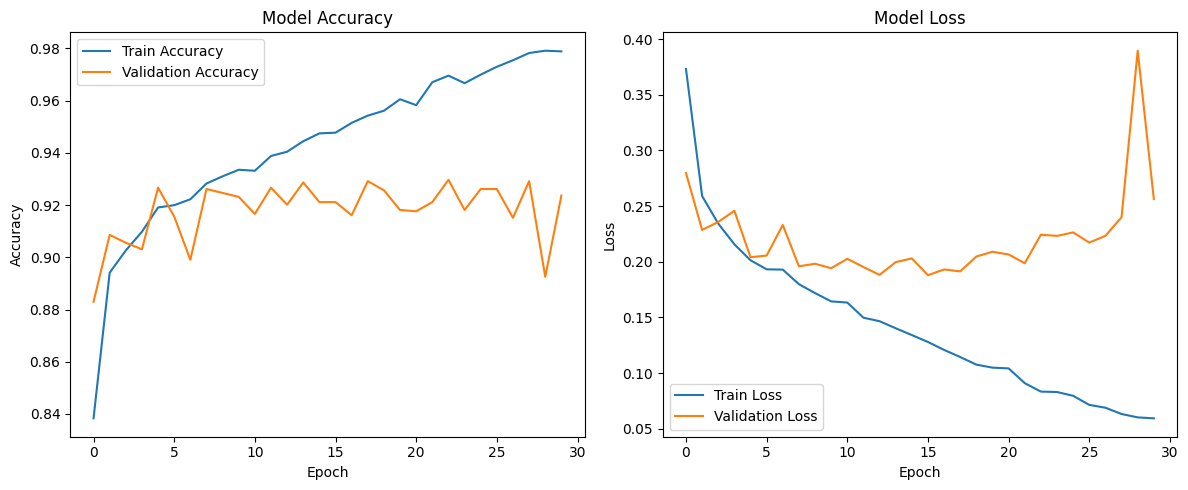

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Save Model
model.save(os.path.join(os.curdir, 'models', 'model_2_deep_learning_customized_standalone.h5'))